In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import aaanalysis as aa

# Loading scales and sequence data using AAanalysis
AAanalysis is a python framework for sequence-based and alignment-free protein prediction. It comprises several example datasets for sequence and residue predictions tasks, which can be retrieved using the aa.load_dataset() function. Amino acid scales (most from AAindex) and their hierarchical classification (named AAontology) can be accessed using the aa.load_scales() function. Since redundancy is an essential problem for machine learning tasks, the AAclust() object provides a lightweight wrapper for sklearn clustering algorithms such as Agglomerative clustering. AAclust clusters a set of scales and selects for each cluster the most representative scale (i.e., the scale closes to the cluster center).

In [2]:
# Load training data
df_info = aa.load_dataset()
df = aa.load_dataset(name="SEQ_DISULFIDE", min_len=300, n=100)
print(df)
# Load scales and scale categories from AAanalysis
df_scales = aa.load_scales()
df_cat = aa.load_scales(name="scales_cat")
# Select scales using AAclust
aac = aa.AAclust(model=AgglomerativeClustering, model_kwargs=dict(linkage="ward"))
X = np.array(df_scales).T
scales = aac.fit(X, n_clusters=10, names=list(df_scales))   # Number of clusters = number of selected scales (100 is recommended)
df_cat = df_cat[df_cat["scale_id"].isin(scales)]
df_scales = df_scales[scales]

               entry                                           sequence  label
1        DISULFIDE_2  PLHHLXIGTWTPPGAIFTVQFDDEKLTCKLIKRTEIPQDEPISWXT...      0
4        DISULFIDE_5  GFPELKNDTFLRAAWGEETDYTPVWCMRQAGRYLPEFRETRAAQDF...      0
5        DISULFIDE_6  MKIIRIETSRIAVPLTKPFKTALRTVYTAESVIVRITYDSGAVGWG...      0
7        DISULFIDE_8  AAERVFISPAKYVQGKNVITKIANYLEGIGNKTVVIADEIVWKIAG...      0
9       DISULFIDE_10  MKFTVEREHLLKPLQQVSGPLGGRPTLPILGNLLLQVADGTLSLTG...      0
...              ...                                                ...    ...
2130  DISULFIDE_2131  DSLDEQRSRYAQIKQAWDNRQMDVVEQMMPGLKDYPLYPYLEYRQI...      1
2132  DISULFIDE_2133  SRTHVCQSDTHIFIIMGASGDLAKKKIYPTIWWLFRDGLLPENTFI...      1
2134  DISULFIDE_2135  ATTYNAVVSKSSSDGKTFKTIADAIASAPAGSTPFVILIKNGVYNE...      1
2137  DISULFIDE_2138  KQFSQEFRDGYSILKHYGGNGPYSERVSYGIARDPPTSCEVDQVIM...      1
2147  DISULFIDE_2148  MRNRREVSKLLSERVLLLDGAYGTEFMKYGYDDLPEELNIKAPDVV...      1

[200 rows x 3 columns]


# Feature Engineering
*Comparative Physicochemical Profiling (CPP)* is a sequence-based feature engineering algorithm aiming at identifying a set of features that is most discriminant between two sets of sequences, called test set and reference set. A CPP feature is a combination of a *Part*, a *Split*, and a *Scale*. *Parts* are combination of a target middle domain (TMD) and N- and C-terminal adjacent regions (JMD-N and JMD-C, respectively). They can be obtained from a dataframe with sequences using the sf.get_df_parts() method from the SequenceFeature class, where the length of the JMDs can be specified. These *Parts* can be split into various continuous segments or discontinuous patterns, for which the sf.get_split_kws() method creates a parameter dictionary. The scales (and or scale categories), the parts, and the split parameters are used to instantiates the CPP class. Running the CPP algorithm creates all *Part*, *Split*, *Split* combinations and filters a selected maximum (via 'n_filter' argument) of non-redundant features.

In [3]:
# Feature Engineering
y = list(df["label"])
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df, jmd_n_len=50, jmd_c_len=50)
args = dict(df_scales=df_scales, df_parts=df_parts, accept_gaps=True)
# Small set of features (300 features created)
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])
cpp = aa.CPP(df_cat=df_cat, **args, split_kws=split_kws)
df_feat = cpp.run(labels=y, tmd_len=200, n_processes=8, n_filter=100)

1. CPP creates 30 features for 200 samples
   |#########################| 100.00%
2. CPP pre-filters 1 features (5%) with highest 'abs_mean_dif' and 'max_std_test' <= 0.2
3. CPP filtering algorithm
4. CPP returns df with 1 unique features including general information and statistics


# Machine learning
The SequenceFeature class provides as well a method to create a feature matrix from a given set of CPP features.

In [4]:
X = sf.feat_matrix(**args, features=df_feat["feature"])
# ML evaluation
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=8) # Set n_jobs=1 to disable multi-processing
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

Mean accuracy of 0.55


In [5]:
# Default set of features (around 100.000 features created)
split_kws = sf.get_split_kws()
cpp = aa.CPP(df_cat=df_cat, **args, split_kws=split_kws)
df_feat = cpp.run(labels=y, tmd_len=200, n_processes=8, n_filter=100)
X = sf.feat_matrix(**args, features=df_feat["feature"])
# ML evaluation
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=1)  # Set n_jobs=1 to disable multi-processing
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

1. CPP creates 9900 features for 200 samples
   |#########################| 100.00%
2. CPP pre-filters 495 features (5%) with highest 'abs_mean_dif' and 'max_std_test' <= 0.2
3. CPP filtering algorithm
4. CPP returns df with 32 unique features including general information and statistics
Mean accuracy of 0.74


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

<Figure size 640x480 with 0 Axes>

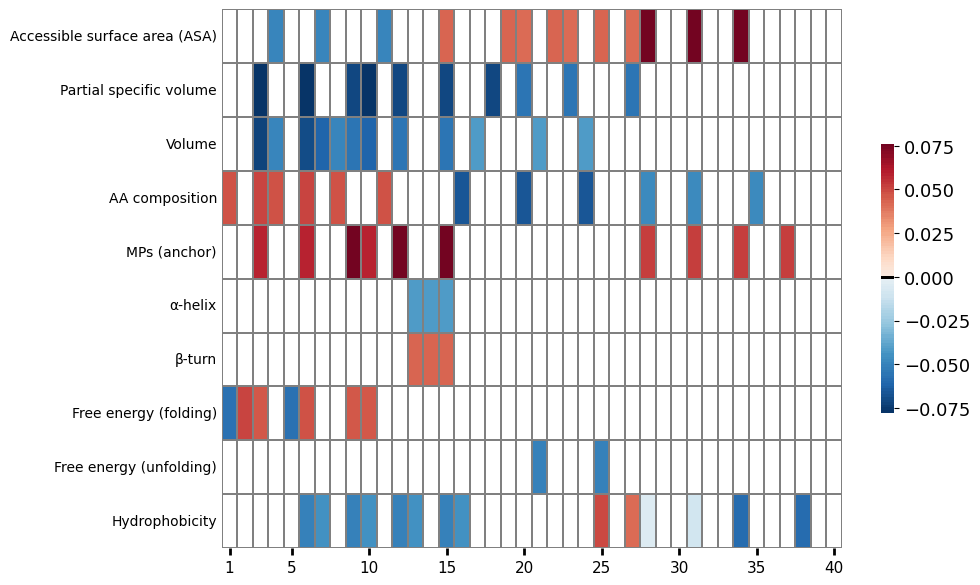

In [6]:
import matplotlib.pyplot as plt
cpp.plot_heatmap(df_feat=df_feat)
plt.show()